In [0]:
!nvidia-smi

Thu Apr  9 12:18:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [0]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170890 sha256=3e87d1644599009aad8f859f2961dfd6417dc38deaed444828d96ffec924c95e
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [0]:
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json

Downloading...
From: https://drive.google.com/uc?id=1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT
To: /content/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 33.7MB/s]


In [0]:
import pandas as pd
plates_df = pd.read_json('indian_number_plates.json',lines = True)

In [0]:
plates_df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [0]:
import os

os.makedirs('number_plates',exist_ok = True)

In [0]:
import urllib
from PIL import Image

dataset  = dict()
dataset['image_name'] = []
dataset['top_x'] = []
dataset['top_y'] = []
dataset['bot_x'] = []
dataset['bot_y'] = []
dataset['class_name'] = []

counter = 0
for index,row in plates_df.iterrows():
  img = urllib.request.urlopen(row['content'])
  img = Image.open(img)
  img = img.convert('RGB')
  img.save(f'number_plates/licensed_car_{counter}.jpeg','JPEG')

  dataset["image_name"].append(
      f'number_plates/licensed_car_{counter}.jpeg'
    )

  data = row["annotation"]

  width = data[0]["imageWidth"]
  height = data[0]["imageHeight"]

  dataset["top_x"].append(
      int(round(data[0]["points"][0]["x"] * width))
    )
  dataset["top_y"].append(
      int(round(data[0]["points"][0]["y"] * height))
    )
  dataset["bot_x"].append(
      int(round(data[0]["points"][1]["x"] * width))
    )
  dataset["bot_y"].append(
      int(round(data[0]["points"][1]["y"] * height))
    )
  dataset["class_name"].append("license_plate")

  counter += 1
print("Downloaded {} car images.".format(counter))



Downloaded 237 car images.


In [0]:
df = pd.DataFrame(dataset)

In [0]:
df.head()

,image_name,top_x,top_y,bot_x,bot_y,class_name
0,number_plates/licensed_car_0.jpeg,582,274,700,321,license_plate
1,number_plates/licensed_car_1.jpeg,80,382,288,449,license_plate
2,number_plates/licensed_car_2.jpeg,41,219,115,260,license_plate
3,number_plates/licensed_car_3.jpeg,217,313,359,359,license_plate
4,number_plates/licensed_car_4.jpeg,209,220,866,554,license_plate


In [0]:
import matplotlib.pyplot as plt
from pylab import rcParams
import cv2
rcParams['figure.figsize'] = 10,10



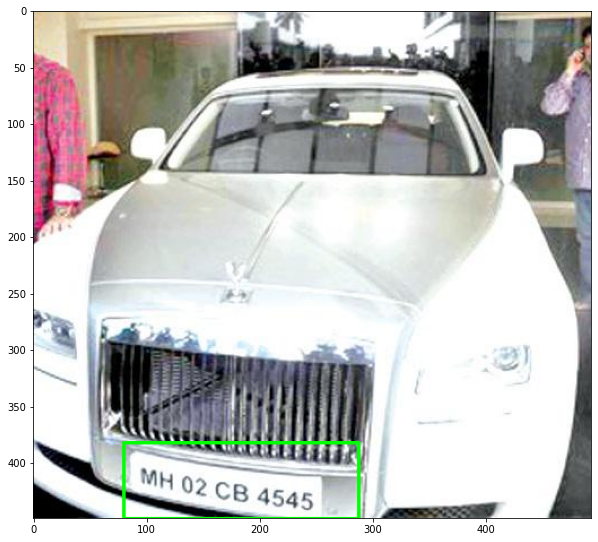

In [0]:
def show_images(r):
  t = df.iloc[r,:]
  img = cv2.imread(t.image_name)
  x1 , y1 = t.top_x,t.top_y
  x2,y2 = t.bot_x,t.bot_y
  color = (0,255,0)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  image = cv2.rectangle(img,(x1,y1),(x2,y2),color,2)

  plt.imshow(image)
  plt.show()

show_images(1)

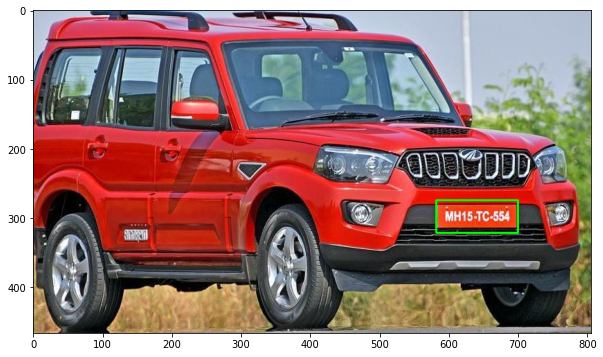

In [0]:
show_images(0)

In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
  df,
  test_size=0.2,
  random_state= 42
)

ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

classes = set(['license_plate'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [0]:
os.makedirs("snapshots", exist_ok=True)
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:01, 245MB/s]


In [0]:


import tensorflow as tf
from tensorflow import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color


model_path = os.path.join(
  'snapshots',
  sorted(os.listdir('snapshots'), reverse=True)[0]
)



In [0]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [0]:
labels_to_names = pd.read_csv(
  CLASSES_FILE,
  header=None
).T.loc[0].to_dict()

{0: 'license_plate'}

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:
image  = read_image_bgr(df.iloc[0,:].image_name)

In [0]:
import numpy as np

boxes, scores, labels = predict(image)

In [0]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name

  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.top_x, image_row.top_y, image_row.bot_x, image_row.bot_y
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

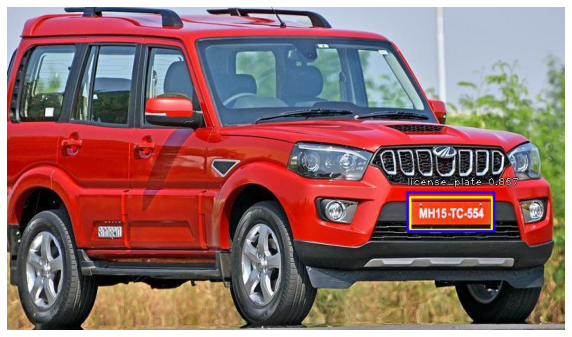

In [0]:
import cv2
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

show_detected_objects(df.iloc[0,:])

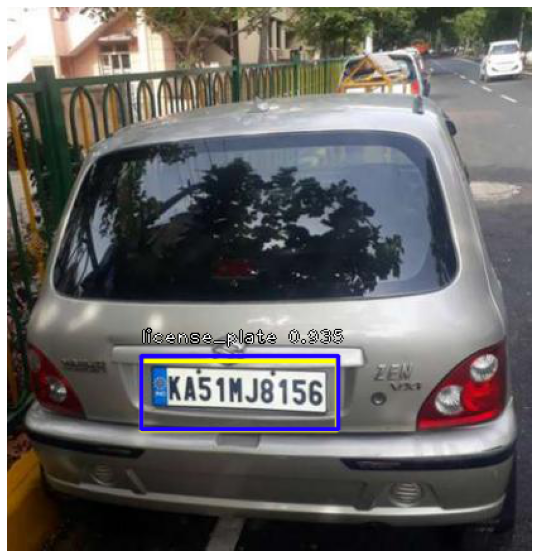

In [0]:
show_detected_objects(df.iloc[5,:])

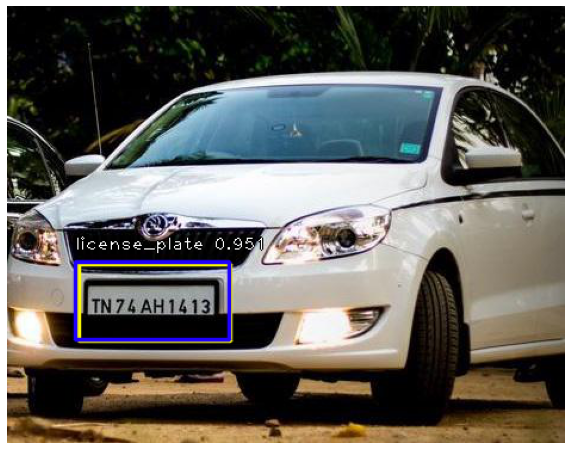

In [0]:
show_detected_objects(df.iloc[17,:])